# Prac 06 Clustering

In this prac we will explore some of the clustering methods available in `sklearn` as well as some of the metrics that we can use to evalutate them.


# Q1
As a warm-up we will start by simulating some data with known labels, and then test out our clustering algorithms using the sum of squared errors.

1. Generate a simulated data set with three classes and three dimensions.
  - Visualise the data.
1. Using the bottom up agglomerative clustering method
  - cluster the data set and determine the optimal number of clusters
  - recluster the data using this optimal clustering
  - view the data clusters
1. Compute the sum of squared errors for each cluster.
  - Write a function to compute sume of squared errors.
1. For each clustering method that was discussed in class (DBSCAN, KMeans, and Gaussian Mixture):
  - Cluster the data
  - Evaluate the SSQ
  - Identify the best clustering metric from the 4 methods tested so far



Do the standard imports

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns


### 1 Generate data
Use `sklearn.datasets.make_classification` to generate a data set with 1000 samples, 3 features, and 3 classes.

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=3,
                           n_informative=3,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           n_classes=3,
                           class_sep=3,
                           # flip_y=0, Leaving this as the defaul 0.001 gives a few 'errors' in the class labels
                           random_state=123)

Visualize the data using a 3D plot.

In [ ]:
def plot3d(X,y):
  fig, ax = plt.subplots(1,1, subplot_kw={'projection':'3d'})

  # create scatter plot for samples from each class
  for class_value in pd.unique(y):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    ax.scatter(X[row_ix, 0], X[row_ix, 1], X[row_ix,2])
  # show the plot
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  plt.show()

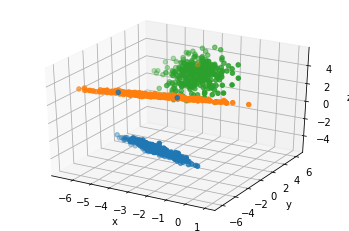

In [ ]:
plot3d(X,y)
# Note that there are a few data points that seem to be sitting in the wrong cluster.

### 2 Use the bottom up agglomerative clustering method
Using the bottom up agglomerative clustering method, cluster the data set and determine the optimal number of clusters.

In [ ]:
# import the method
from sklearn.cluster import AgglomerativeClustering

Firstly we run the clustering method with a distance threshold of zero and no indication of the number of clusters.
This will generate *all* possible clusters, which we can then visualise and determine the optimal number.

In [ ]:
model_ac_full = AgglomerativeClustering(distance_threshold=0,
                                        n_clusters=None)

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

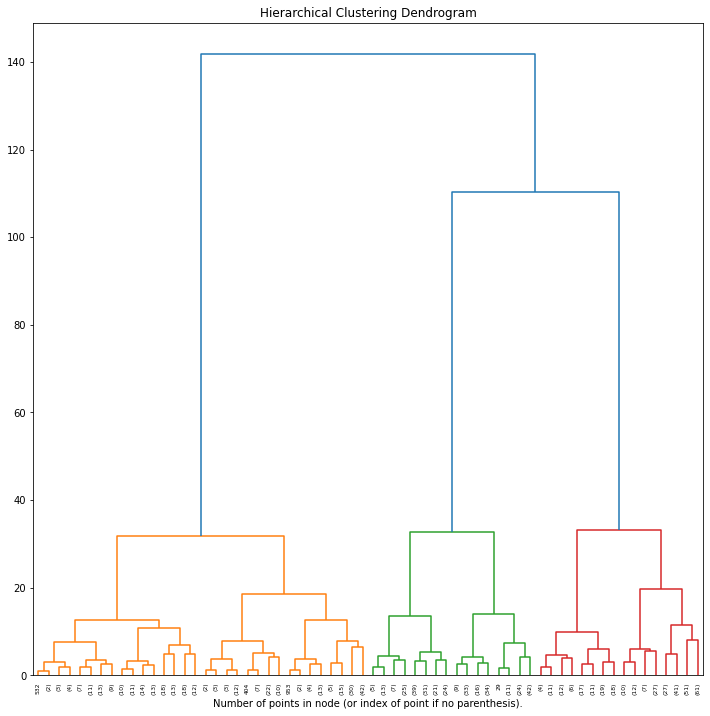

In [ ]:
# Now plot the dendrogram.
plt.figure(figsize=(12,12))
plt.title('Hierarchical Clustering Dendrogram')
# Fit the model
model_ac_full.fit(X)
# plot the top five levels of the dendrogram
plot_dendrogram(model_ac_full, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Using the method described in class, inspect the above figure, and decide how many clusters should be used.

Once this has been done, redo the clustering with that number of clusters.

In [ ]:
model_ac = AgglomerativeClustering(n_clusters=3)

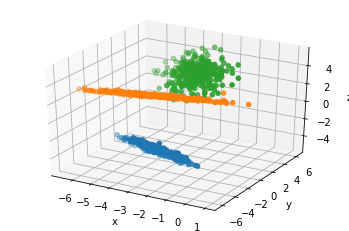

In [ ]:
yhat = model_ac.fit_predict(X)
plot3d(X,yhat)
# note that the spurious data points shown before are not 'correctly' labeled.

### 3 Compute the sum of squared errors
1. Compute the sum of squared errors (SSQ) for each cluster.
  - Write a function to compute sume of squared errors.
  - Print the SSQ for each cluster, and for the total.

In [ ]:
def calc_ssq(X, yhat):
  clusters = np.unique(yhat)
  ssq = 0
  for c in clusters:
    cluster = X[np.where(yhat==c)]
    centroid = np.mean(cluster, axis=0)
    distances = cluster-centroid
    ssq += np.sum(distances**2)
  #print(ssq)
  return ssq

In [ ]:
yhat = model_ac.fit_predict(X)
calc_ssq(X, yhat)

3130.9629826894597

### 4 Test further methods
For each clustering method that was discussed in class (DBSCAN, KMeans, and Gaussian Mixture):
  - Cluster the data assuming 3 clusters
  - Evaluate the SSQ for that method
  - Identify the best clustering metric from the 4 methods tested so far

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
model_gm = GaussianMixture(n_components=3)
yhat = model_gm.fit_predict(X)
calc_ssq(X,yhat)

3139.679294134914

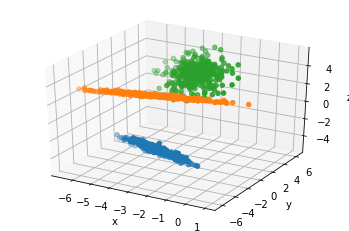

In [ ]:
plot3d(X,yhat)

In [ ]:
model_km = KMeans(n_clusters=3)
yhat = model_km.fit_predict(X)
calc_ssq(X,yhat)

3110.6705580544476

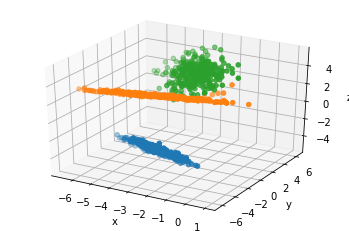

In [ ]:
plot3d(X,yhat)

In [ ]:
model_db = DBSCAN()
yhat = model_db.fit_predict(X)
calc_ssq(X,yhat)

3978.147066486108

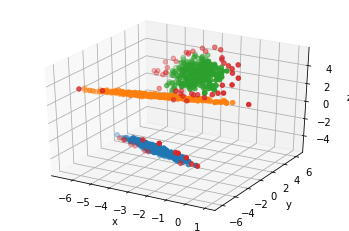

In [ ]:
plot3d(X,yhat)

Note that DBSCAN doesn't allow you to specify a number of clusters.
How many clusters were generated by DBSCAN and how many outlier points were there?

In [ ]:
# Look at the uniquie labels
# -1 => noise/outlier
# 0 or greater  => cluster label
np.unique(model_db.labels_)

array([-1,  0,  1,  2])

# Q2
Using the datasets and classifiers from Q1 we will now explore different validation metrics, and how we can use them to choose the 'best' clustering properties.

1. Use metrics discussed in class to evaluate each of the clustering methods in Q1
  - Use metrics:
    - sum of squared errors (SSQ)
    - Silhouette
    - Intra/Inter cluster distance ration, a.k.a the Davies Bouldin Score
  - Use methods:
    - Agglomerative Clustering
    - GaussianMixture
    - KMeans
    - DBSCAN
  - Create a matrix of metric/method showing the scores for each combination
2. Using the KMeans clustering method:
  - Measure the SSQ score for values of k=2-20
  - Plot the result and choose the optimal value of k
  - Repeat the above for the remaining metrics

## 1 Create a matrix of scores
Use metrics discussed in class to evaluate each of the clustering methods in Q1
  - Use metrics:
    - sum of squared errors (SSQ)
    - Silhouette
    - Intra/Inter cluster distance ration, a.k.a the Davies Bouldin Score
  - Use methods:
    - Agglomerative Clustering
    - GaussianMixture
    - KMeans
    - DBSCAN
  - Create a matrix of metric/method showing the scores for each combination

In [ ]:
from sklearn import metrics

methods = [model_ac, model_gm, model_km, model_db]
scorers = [calc_ssq, metrics.davies_bouldin_score, metrics.silhouette_score]
# see below for ordering of methods/scorers

scores = np.empty(shape=(3,4))
for i,m in enumerate(methods):
  yhat = m.fit_predict(X)
  for j,scorer in enumerate(scorers):
    score = scorer(X,yhat)
    scores[j,i] = score

In [ ]:
df = pd.DataFrame(scores,
                  columns=['Agglomerative', 'GaussianMixture', 'KMeans','DBSCAN'],
                  index=["SSQ", 'DaviesBouldin', 'Silhouette'])
df

,Aglomerative,GaussianMixture,KMeans,DBSCAN
SSQ,3130.962983,3139.679294,3110.670558,3978.147066
DaviesBouldin,0.491547,0.491721,0.492232,1.844276
Silhouette,0.652397,0.651803,0.653715,0.592118


## 2 Use KMeans
Using the KMeans clustering method:
  - Measure the SSQ score for values of k=1-20
  - Plot the result and choose the optimal value of k
  - Repeat the above for the remaining metrics

In [ ]:
km_ssq = []
for k in range(1,21):
  km = KMeans(n_clusters=k)
  yhat = km.fit_predict(X)
  ssq = calc_ssq(X,yhat)
  km_ssq.append(ssq)

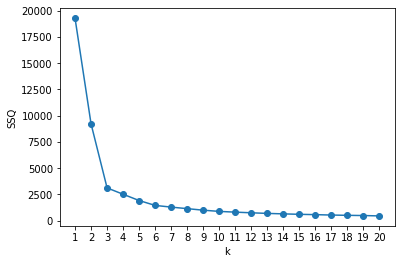

In [ ]:
k_vals = range(1,len(km_ssq)+1)
fig, ax = plt.subplots(1,1)
ax.plot(k_vals,
        km_ssq,
        'o-')
ax.set_xlabel('k')
ax.set_ylabel('SSQ')
ax.set_xticks(k_vals)
plt.show()

In [ ]:
# now for the other two metrics
km_db = []
for k in range(2,21):
  km = KMeans(n_clusters=k)
  yhat = km.fit_predict(X)
  ssq = metrics.davies_bouldin_score(X,yhat)
  km_db.append(ssq)

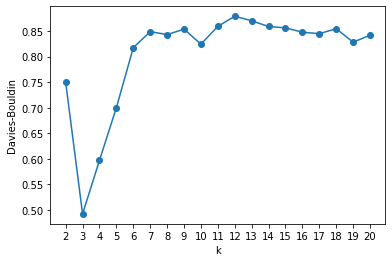

In [ ]:
k_vals = range(2,21)
fig, ax = plt.subplots(1,1)
ax.plot(k_vals,
        km_db,
        'o-')
ax.set_xlabel('k')
ax.set_ylabel('Davies-Bouldin')
ax.set_xticks(k_vals)
plt.show()

In [ ]:
km_s = []
for k in range(2,21):
  km = KMeans(n_clusters=k)
  yhat = km.fit_predict(X)
  ssq = metrics.silhouette_score(X,yhat)
  km_s.append(ssq)

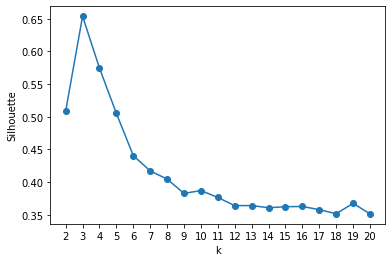

In [ ]:
k_vals = range(2,21)
fig, ax = plt.subplots(1,1)
ax.plot(k_vals,
        km_s,
        'o-')
ax.set_xlabel('k')
ax.set_ylabel('Silhouette')
ax.set_xticks(k_vals)
plt.show()